In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
import preprocessing as pre

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from graficos_modelos import graficar_auc_roc, graficar_matriz_confusion, graficar_curva_aprendizaje
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, mapear_target_binario, mapear_target_binario_a_categorico

ModuleNotFoundError: No module named 'tensorflow'

# Redes neuronales

Definimos el método que generará la red neuronal con una arquitectura constante, la cual tendra dos capas ocultas de 10 y 8 neuronas respectivamente. A su vez, se utilizara la funcion de activación de tangente hiperbólica en las capas ocultas, y una sigmoidea en la capa de output ya que se trata de un problema de clasificación binaria. Por el mismo motivo, la funcion de perdida a optimizar será la cross-entropy.

El método de regularización a utilizar sera dropout con parametro 0.25 para mantener el modelo lo más simple posible y no sobrecargarlo con computo.

In [2]:
def crear_red(optimizer):
    red_neuronal = Sequential()
    red_neuronal.add(Dense(8, input_dim=18, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(5, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(1, activation='sigmoid'))
    red_neuronal.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=keras.metrics.AUC(name="auc"))
    return red_neuronal

Dada la alta complejidad temporal de las redes neuronales, nos vemos obligados a tratarla de una manera distinta al resto de modelos. 
Esta será tal que, mateniendo una misma arquitectura, probaremos dos combinaciones distintas de hiperparametros para un mismo preprocesamiento, y la que mejor performance tenga sobre holdout, será probada con el segundo preprocesamiento. Finalmente, se comaprará la misma red con los mismos hiperpametros pero que entrenada con datos preprocesados de distinta manera, y la que mejor métricas produzca, será utilizada para la predicción final y para compararse con las otras familias de modelos

### Obtención de datos 

In [3]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, X_holdout, y_train, y_test, y_holdout = separar_dataset_train_val_holdout(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
X_holdout.is_copy=False
y_train.is_copy=False
y_test.is_copy=False
y_holdout.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()

y_holdout.set_index('id', inplace=True)
y_holdout = y_holdout.sort_values(by=['id'], ascending=True).copy()

### Definiendo distintos preprocesamientos

In [4]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None, scaler=None):
    df = df_original.copy(deep=True)
    df = pre.limpiar_datos(df)
    df = pre.aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    pre.eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])

    if(imputer is None):
        imputer = pre.entrenar_iterative_imputer(df)
    df = pre.imputar_missings_iterative(df, imputer)
    
    if(scaler is None):
        scaler = pre.entrenar_normalizador_minmax(df)
    df = pre.normalizar_dataframe(df, scaler)
    
    return df, imputer, scaler

Primer preprocesamiento: La idea de este preprocesamiento es que sea mas simple que el segundo, para poder comprar distintos niveles de complejidad y sofisticación a la hora de preprocesar datos. En este caso, se limpian los datos transformando la feature de presión atmosférica tarde a float, ya que originalmente tiene valores invalidos con tipo de dato string y además se pasan los nulos a nan de numpy. También se eliminan todas menos las features categóricas  menos "llovieron_hamburguesas_hoy" ya que por lo visto en la parte 1 esta es la única que proporciona información relevante respecto al target. Finalmente, para el caso de que no se reciba un imputer, creara y entrenará un iterative imputer, y ya sea reciendolo como parametro o generadolo, se usará dicho imputer para rellenar los missings. Lo mismo sucede con la normalización de los datos, ya que si no se recibe ningun normalizador, se entrenara un normalizador min max con parametros por defecto (rango 0 a 1) y se normalizaran los datos. Creemos que este normalizador es más génerico que el standard el cual usa valores del propio dataset para normalizar, y por ende menos sofisticado.

In [5]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, scaler=None):    
    df = df_original.copy(deep=True)
    df = pre.limpiar_datos(df)
    pre.eliminar_features(df, ['dia','barrio'])
    df = pre.aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    df = pre.aplicar_hashing_trick(df, ['direccion_viento_tarde','direccion_viento_temprano','rafaga_viento_max_direccion'], [3,3,3])

    if(imputer is None):
        imputer = pre.entrenar_iterative_imputer(df)
    df = pre.imputar_missings_iterative(df, imputer)
    
    if(scaler is None):
        scaler = pre.entrenar_normalizador_standard(df)
    df = pre.normalizar_dataframe(df, scaler)
    df = pre.reduccion_PCA(df, 18)

    return df, imputer, scaler

Segundo preprocesamiento: Tiene como objetivo ser bastante sofisticado y complejo. Esto se puede observar ya que además de limpiar los datos al igual que el primer preprocesamiento, unicamente se descartan las features dia y barrio (también por el análisis de la parte 1), y las otras categóricas se transforman tanto con dummy encoding cuando la dimensionalidad de valores posibles es baja (solo para llovieron_hamburguesas_hoy) como con hashing trick a vectores de tres dimensiones para una dimensionalidad de valores mas alta (direcciones de vientos). Utiliza nuevamente el iterative imputer, pero en lugar de usar el normalizador min max, utiliza el normalizador standard el cual como se menciono con anterioridad, esta creado sobre valores del mismo dataset. Finalmente, dado que se aumento bastante la dimensionalidad del dataset con los metodos de transformación de features categóricas, se aplicara una reducción PCA a 16 dimensiones, el cual implica que estamos reduciendo la dimensión del dataset a una dimensión mucho más pequeña para que el input de la red sea el mismo en ambos casos. Esta reducción podría generar perdida de información la cual se vería reflejada en la performance del modelo.

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [6]:
X_train_1, imputer_entrenado_1, scaler_entrenado_1  = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1, scaler_entrenado_1 = preprocesamiento_1(X_test, imputer_entrenado_1, scaler_entrenado_1)

In [7]:
X_train_2, imputer_entrenado_2, scaler_entrenado_2  = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, scaler_entrenado_2 = preprocesamiento_2(X_test, imputer_entrenado_2, scaler_entrenado_2)

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Los hiperparametros a definir en una red neuronal son:
- loss: Función de perdida a optimizar. En nuestro caso, por ser clasificación binaria, debe ser o softmax o binary cross-entropy. Elegimos la última por simpleza.
- optimizer: El optimizador que se utilizará para encontrar los mejores parametros (pesos y biases) de la red. 
    - learning_rate: Es un hiperparametro del optimizador que indica cuan grande sera el "aprendizaje" en cada epoca. Si es pequeño, tomara mas epocas el entrenamiento pero tendrá menos riesgo de diverger en los parametros como lo haría un learning rate alto
- metrics: Métricas que se utilizaran para mostrar y validar (en caso de usar callbacks) el resultado del entrenamiento
- epochs: Cantidad de iteraciones que realizara la red para ajustar sus pesos y biases

Planteamos como posibles hiperpametros dos optimizadores, Adam que resulta un optimizador de complejidad media, y Adagrad que es un optimizador de complejidad mas elevada. 

Como el problema a resolver no es extremadamente complejo, no hay necesidad de complejizar tanto el computo de la red con optimizadores mas elaborados para obtener una buena performance.

Los learning rates propuestos se consideran relativamente valores bajos para que el aprendizaje sea suave y no abrupto/errático

In [8]:
mapeo_binario_v = np.vectorize(mapear_target_binario)

In [9]:
y_train_np = y_train['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_train_binario = mapeo_binario_v(y_train_np)

y_test_np = y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_test_binario = mapeo_binario_v(y_test_np)

y_holdout_np = y_holdout['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_holdout_binario = mapeo_binario_v(y_holdout_np)

Creamos entonces la red con el optimizador adam, el cual esta en el medio en la escala de complejidad y performance, y entrenamos un numero arbitrario de epochs. Además agregamos criterio de early stopping para no sobreentrenar la red y que overfitee.

In [10]:
red_1 = crear_red(keras.optimizers.Adam(learning_rate=0.0001))
red_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 152       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_auc', patience=50, mode='max')

In [12]:
historia_1 = red_1.fit(
    X_train_1, y_train_binario, epochs=500, 
    validation_data=(X_test_1, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/500
3199/3199 [==============================] - 3s 698us/step - loss: 0.5892 - auc: 0.5720 - val_loss: 0.4788 - val_auc: 0.7923
Epoch 2/500
3199/3199 [==============================] - 2s 641us/step - loss: 0.4647 - auc: 0.7715 - val_loss: 0.4257 - val_auc: 0.8243
Epoch 3/500
3199/3199 [==============================] - 2s 660us/step - loss: 0.4359 - auc: 0.8036 - val_loss: 0.4082 - val_auc: 0.8376
Epoch 4/500
3199/3199 [==============================] - 2s 631us/step - loss: 0.4237 - auc: 0.8162 - val_loss: 0.4002 - val_auc: 0.8436
Epoch 5/500
3199/3199 [==============================] - 2s 632us/step - loss: 0.4164 - auc: 0.8239 - val_loss: 0.3954 - val_auc: 0.8471
Epoch 6/500
3199/3199 [==============================] - 2s 628us/step - loss: 0.4117 - auc: 0.8281 - val_loss: 0.3917 - val_auc: 0.8499
Epoch 7/500
3199/3199 [==============================] - 2s 640us/step - loss: 0.4086 - auc: 0.8303 - val_loss: 0.3888 - val_auc: 0.8515
Epoch 8/500
3199/3199 [==================

### Curva de aprendizaje


Graficamos la curva de aprendizaje para tener una mejor idea de como fue el entrenamiento de nuestra red

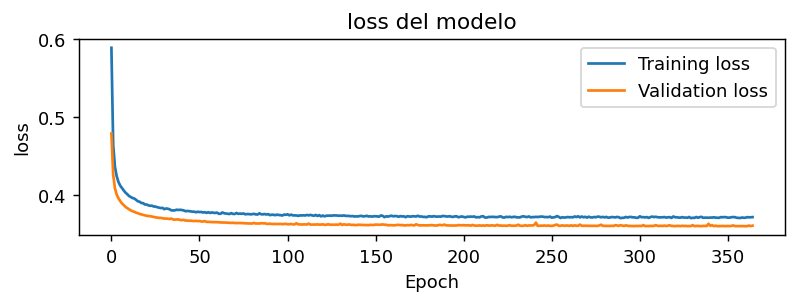

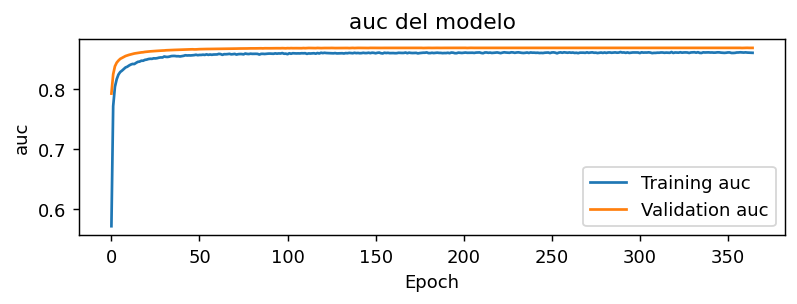

In [13]:
graficar_curva_aprendizaje(historia_1,'loss')
graficar_curva_aprendizaje(historia_1,'auc')

De las curvas de aprendizaje del modelo, podemos tomar varias conclusiones:
- El learning rate adecuado pues el aprendizaje es suave, no se ven practicamente picos erráticos, ni en la curva de perdida ni en la curva de la métrica a optimizar
- El modelo no overfitea, o lo hace muy poco ya que la brecha entre las curvas de training y validation es mínima, indicando que lo que aprende de training, son generalizaciones y conceptos que lo ayudan a dar buenas métricas sobre el set de validación
- El error de perdida del modelo es bajo, pero idealmente queremos que sea lo mas cercano a 0, y por ende queremos mejorarlo

### Predicción del modelo sobre test

Una vez que vimos que no se produjo un overfitting (dado que las curvas de validation y training son muy similares) y que la métrica alcanzada es lo suficientemente buena, realizamos la predicción sobre los valores del dataset de validation, y gráficamos la curva AUC-ROC y la matriz de confusión

In [15]:
y_pred_1 = red_1.predict(X_test_1)

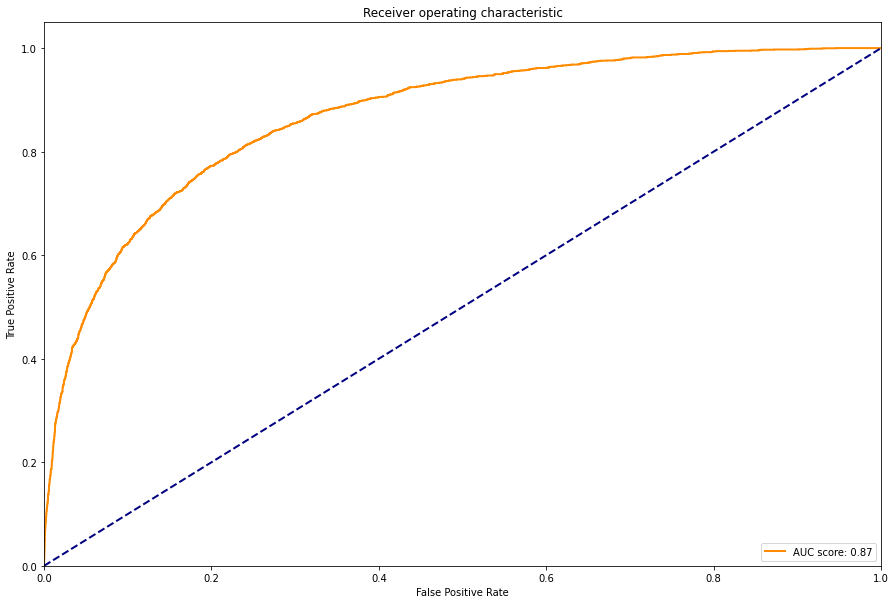

AUC-ROC para este modelo es: 0.8682066705063279


In [16]:
graficar_auc_roc(y_test_binario, y_pred_1) 

De la curva AUC-ROC vemos que el primer modelo probado con un optimizador no demasiado complejo como lo es adagrad, alcanzamos un valor relativamente bueno de la métrica, estando por encima de casi todos los modelos mas simples, y a la par de los otros modelos complejos como lo son los ensambles. Esto era esperable ya que las redes neuronales suelen funcionar mejor para muchos problemas, a cambio de perder entendimiento de lo que sucede por dentro. Es decir, se vuelven una caja negra a cambio de performance.

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


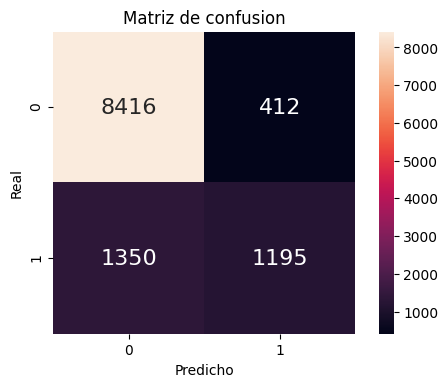

In [17]:
graficar_matriz_confusion(y_test_binario, y_pred_1.round())

De la matriz de confusión y del classification report vemos que a pesar de tener un buen AUC-SCORE, las otras métricas no son excepcionalmente buenas, si no mas bien similares al promedio de modelos evaluados en esta parte, teniendo un f1 score levemente mejor que naive bayes y arbol de clasificación, y un accuracy un punto superior al del arbol (84% vs 85%). Así que si bien en general es mejor que los modelos mas simples, la diferencia no tan significativa como para dejar de considerar a estos últimos por su eficiencia temporal y espacial.

In [18]:
print(classification_report(y_test_binario, y_pred_1.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.86      0.95      0.91      8828
          si       0.74      0.47      0.58      2545

    accuracy                           0.85     11373
   macro avg       0.80      0.71      0.74     11373
weighted avg       0.84      0.85      0.83     11373



Ahora, intentaremos mejorar las métricas obtenidas con los primeros hiperparametros empleando un optimizador mas sofisticado que adam, como lo es adagrad, y ampliando la cantidad de epochs a 1000.

In [19]:
red_1_sofisticada = crear_red(keras.optimizers.Adagrad(learning_rate=0.0001))
red_1_sofisticada.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 152       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [20]:
historia_1_sofisticada = red_1_sofisticada.fit(
    X_train_1, y_train_binario, epochs=1000, 
    validation_data=(X_test_1, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
3199/3199 [==============================] - 3s 718us/step - loss: 0.6747 - auc: 0.4077 - val_loss: 0.6384 - val_auc: 0.1916
Epoch 2/1000
3199/3199 [==============================] - 2s 703us/step - loss: 0.6528 - auc: 0.4124 - val_loss: 0.6229 - val_auc: 0.1907
Epoch 3/1000
3199/3199 [==============================] - 2s 657us/step - loss: 0.6412 - auc: 0.4182 - val_loss: 0.6131 - val_auc: 0.1912
Epoch 4/1000
3199/3199 [==============================] - 2s 638us/step - loss: 0.6331 - auc: 0.4240 - val_loss: 0.6061 - val_auc: 0.1918
Epoch 5/1000
3199/3199 [==============================] - 2s 652us/step - loss: 0.6268 - auc: 0.4272 - val_loss: 0.6007 - val_auc: 0.1920
Epoch 6/1000
3199/3199 [==============================] - 2s 657us/step - loss: 0.6213 - auc: 0.4329 - val_loss: 0.5964 - val_auc: 0.1925
Epoch 7/1000
3199/3199 [==============================] - 2s 629us/step - loss: 0.6199 - auc: 0.4292 - val_loss: 0.5928 - val_auc: 0.1940
Epoch 8/1000
3199/3199 [==========

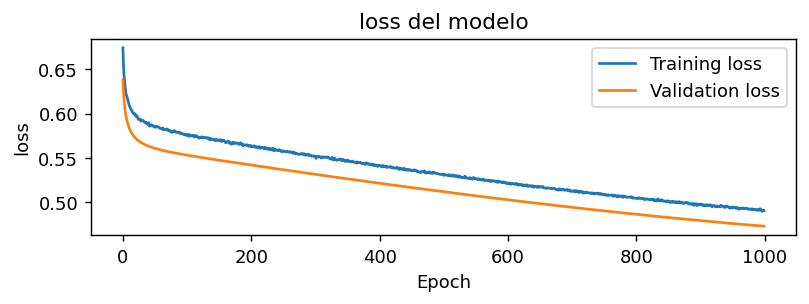

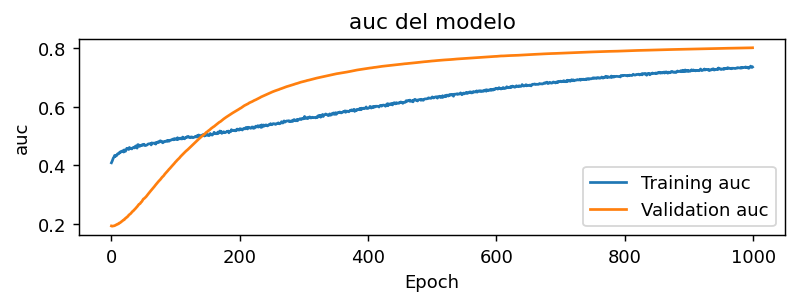

In [21]:
graficar_curva_aprendizaje(historia_1_sofisticada,'loss')
graficar_curva_aprendizaje(historia_1_sofisticada,'auc')

Observando ámbos gráficos de la historia de entrenamiento, vemos particularidades que no habiamos visto en el modelo mas simple:
- Se ve un indicio de overtfit, ya que la brecha entre ámbas curvas en ambos graficos es bastante amplia
- El error de loss cuando termina el entrenamiento es 0.1 punto mayor al modelo inicial (0.35 vs 0.45)
- Curiosamente, la curva de training tiene una forma totalmente distinta a validation en cuando a la métrica auc-score se refiere. La curva del set de validación da un salto abrupto y luego se mantiene constante, mientras que la curva de training se asemeja mas a una función lineal. Esto probablemente sea producto del overfitting mencionado con anterioridad.
- El learning rate parecería ser correcto ya que nuevamente se ven curvas suaves, sin picos.

Probemos ahora predecir sobre train con nuestra otra red:

In [22]:
y_pred_1_sofisticado = red_1_sofisticada.predict(X_test_1)

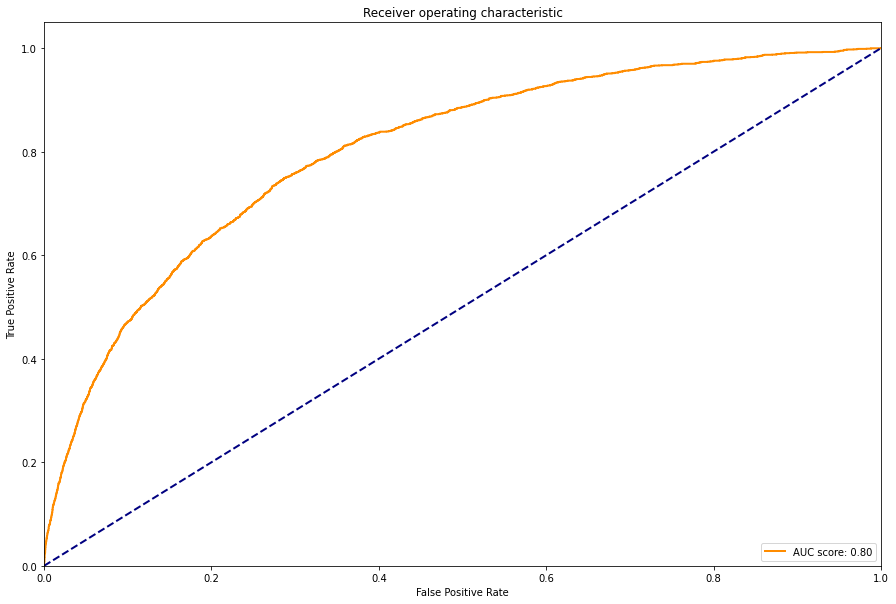

AUC-ROC para este modelo es: 0.80110934755729


In [23]:
graficar_auc_roc(y_test_binario, y_pred_1_sofisticado) 

De la curva AUC-ROC, podemos observar que nuestro intento de mejorar la performance aumentando la complejidad del entrenamiento de la red no fue muy util ya que esta es bastante mas inferior a la de primer red, la cual emplea un optimizador mas sencillo y menos de la mitad de epocas que esta (ya que se frena antes de llegar a las 500 epocas por el criterio de early stopping tomado). Sin embargo, dado que esta red mas sofisticada no se detuvo por early stopping incluso despues de 1000 epocas, creemos que si aumensemos el numero de estas mismas, podriamos mejorar levemente la performance en cuanto a la métrica AUC-ROC se refiere.

A pesar de ser inferior a la primer red mas simple, la metrica AUC-ROC que se observa es superior a la de algunos modelos mas sencillos, como Naive Bayes, SVM y KNN

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


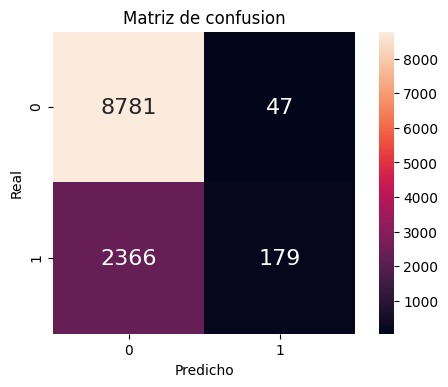

In [24]:
graficar_matriz_confusion(y_test_binario, y_pred_1_sofisticado.round())

Observando la matriz de confusión del modelo complejo, vemos que no solo empeoró la performance en cuanto a la métrica AUC-ROC, si no que también bajo mucho los valores de precision, recall, F1 score y accuracy, estando entre los peores modelos evaluados en esta parte, en cuanto a estas métricas se refiere. Esto se debe a que parecería que la red predice muy pocos valores del target con valor 1 o "si". Es decir, en practicamente la totalidad de los casos, predice que no lloveran hamburguesas al dia siguiente, y en menos de un 10% predice que si lloveran, aunque cuando suele predecir este último caso, acierta en un 75% de las veces. Sin importar si se trata de un True o un False positive, la red predice muy pocas veces el valor del target positivo.

In [25]:
print(classification_report(y_test_binario, y_pred_1_sofisticado.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.79      0.99      0.88      8828
          si       0.79      0.07      0.13      2545

    accuracy                           0.79     11373
   macro avg       0.79      0.53      0.50     11373
weighted avg       0.79      0.79      0.71     11373



Nuestro intento de mejorar la performance resulto completamente contraproducente, habiendo generado un modelo el cual tiene una metrica AUC ROC muy baja. Esto puede deberse a que si bien el optimizador adagrad es mas complejo y en general mas sofisticado, no funciona tan bien para la arquitectura y el set de datos y la prediccion de lluvia de hamburguesas.

# Modelo con preprocesamiento normalizados

Intentaremos mejorar la performance agregando el preprocesamiento de normalizacion de los datos ya que en general suele ayudar a los modelos.

In [26]:
red_2 = crear_red(keras.optimizers.Adam(learning_rate=0.0001))

historia_2 = red_2.fit(
    X_train_2, y_train_binario, epochs=500, 
    validation_data=(X_test_2, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/500
3199/3199 [==============================] - 3s 729us/step - loss: 0.6156 - auc: 0.6352 - val_loss: 0.4570 - val_auc: 0.8290
Epoch 2/500
3199/3199 [==============================] - 2s 653us/step - loss: 0.4507 - auc: 0.7926 - val_loss: 0.3991 - val_auc: 0.8482
Epoch 3/500
3199/3199 [==============================] - 2s 640us/step - loss: 0.4228 - auc: 0.8150 - val_loss: 0.3913 - val_auc: 0.8519
Epoch 4/500
3199/3199 [==============================] - 2s 658us/step - loss: 0.4157 - auc: 0.8205 - val_loss: 0.3882 - val_auc: 0.8534
Epoch 5/500
3199/3199 [==============================] - 2s 625us/step - loss: 0.4107 - auc: 0.8241 - val_loss: 0.3864 - val_auc: 0.8540
Epoch 6/500
3199/3199 [==============================] - 2s 622us/step - loss: 0.4070 - auc: 0.8270 - val_loss: 0.3849 - val_auc: 0.8543
Epoch 7/500
3199/3199 [==============================] - 2s 631us/step - loss: 0.4051 - auc: 0.8282 - val_loss: 0.3839 - val_auc: 0.8546
Epoch 8/500
3199/3199 [==================

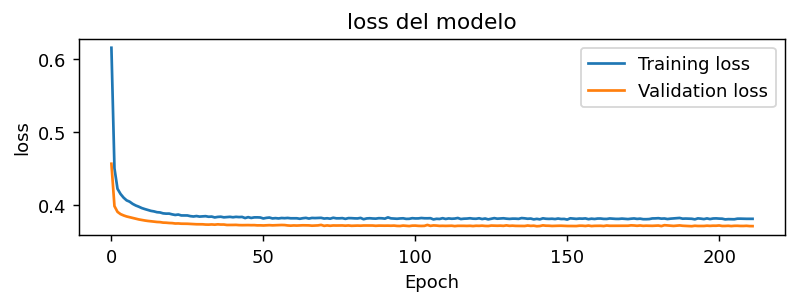

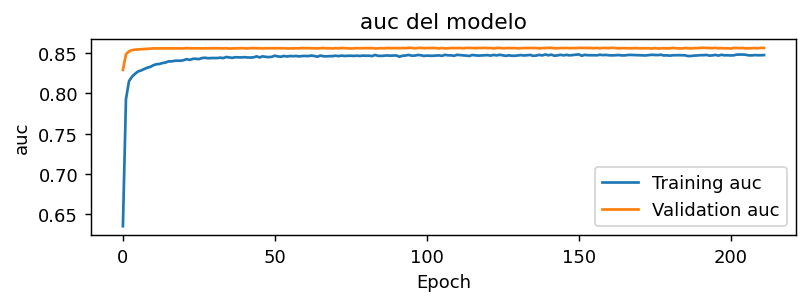

In [27]:
graficar_curva_aprendizaje(historia_2,'loss')
graficar_curva_aprendizaje(historia_2,'auc')

Finalmente, de las curvas de la historia de entrenamiento del último modelo, podemos ver que se asemejan mucho a las del primero (la red con entrenamiento y preprocesamiento simples):
- La brecha entre las curvas de training y validation nuevamente es muy pequeña, dandonos a entender que no se produjo un overfit.
- El learning rate nuevamente es adecuado por la suavidad de las curvas
- Si bien son muy similares a las curvas de la primera red, vemos que el valor mínimo que alcanza el error de perdida es 0.05 puntos mayor que la primera, dandonos a enteder que se ha empeorado la performance

Observemos sus predicciones:

In [28]:
y_pred_2 = red_2.predict(X_test_2)

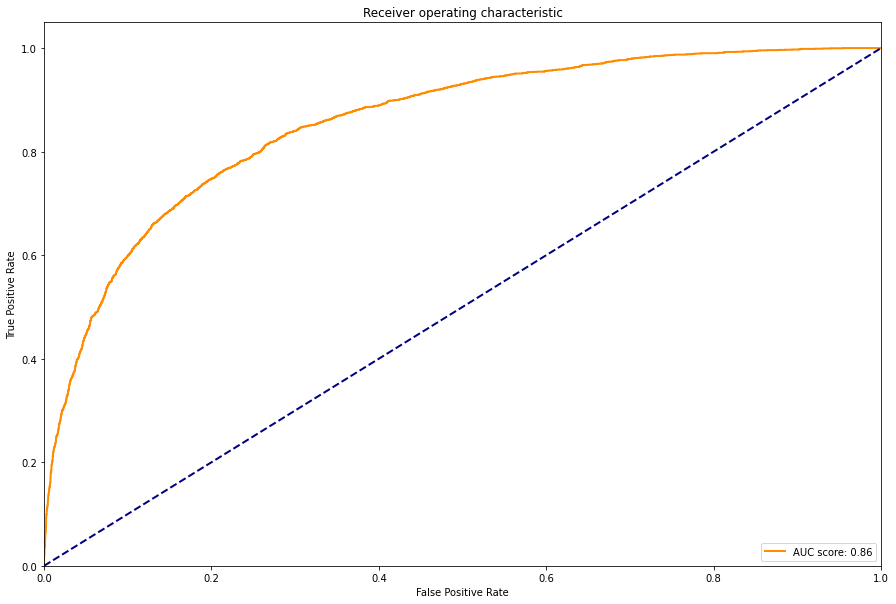

AUC-ROC para este modelo es: 0.85615878393716


In [29]:
graficar_auc_roc(y_test_binario, y_pred_2) 

Vemos en el grafico de la curva AUC-ROC, que el preprocesamiento complejo empeoró levemente la performance, en comparación al preprocesamiento simple. Esto puede deberse a que el segundo preprocesamiento expande el dataset creando nuevas features en lugar de las features categóricas irrelevantes, y luego aplica una reducción de dimensionalidad agresiva, lo cual podría generar que se pierda información útil para predecir el target en esa reducción, y que se mantenga informacíon de las features que por el análisis exploratorio de la parte 1 vimos que eran poco concluyentes.

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


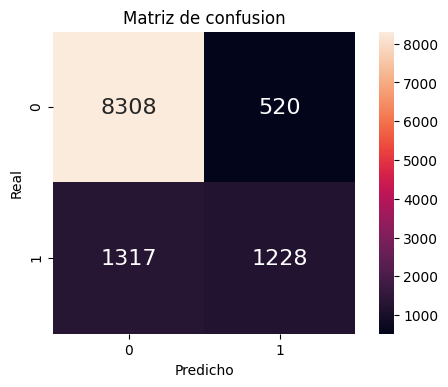

In [30]:
graficar_matriz_confusion(y_test_binario, y_pred_2.round()) 

También en la matriz de confusión y en el clasification report vemos un deterioro de las métricas, que si bien no es tan grave como sucedió cuando intentamos complejizar el entrenamiento de las red mediante sus hiperparametros, es suficientemente significativo. El F1 score cayó 0.04 puntos, y el accuracy cayó en un 1% 

In [31]:
print(classification_report(y_test_binario, y_pred_2.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.86      0.94      0.90      8828
          si       0.70      0.48      0.57      2545

    accuracy                           0.84     11373
   macro avg       0.78      0.71      0.74     11373
weighted avg       0.83      0.84      0.83     11373



## Predicción sobre holdout con el modelo que mejor funcionó en Validation (preprocesamiento 1, adam y 500 epocas)

Nuestros intentos por mejorar la performance mediante complejización del modelo, tanto en los datos como en el entrenamiento, fueron fallidos, dejando en claro que un modelo más simple fue mejor.

Concluimos entonces que por tener metricas auc-roc, accuracy y F1 score más altas, el mejor modelo para predecir será el primero, que utiliza el preprocesamiento más simple eliminando variables categoricas en lugar de transformarlas, y un normalizador mas generalista como lo es min max scaler.

In [ ]:
X_holdout, imputer_entrenado_1, scaler_entrenado_1 = preprocesamiento_1(X_holdout, imputer_entrenado_1, scaler_entrenado_1)
predicciones_holdout = red_1.predict(X_holdout).round()

In [ ]:
graficar_auc_roc(y_holdout_binario, predicciones_holdout) 

In [ ]:
graficar_matriz_confusion(y_holdout_binario, predicciones_holdout.round()) 

In [ ]:
print(classification_report(y_holdout_binario, predicciones_holdout.round(), target_names=['no', 'si']))

## Predicción final con el modelo elegido: Red 1 (preprocesamiento 1, adam y 500 epocas)

Habiendo ya realizado la predicción con el modelo en la partición de holdout, procedemos a realizar la prediccion del dataset nuevo con este modelo y guardarlo en el archivo csv

In [32]:
def formatear_prediccion_red(predicciones):
    pred_finales = []
    for pred in predicciones:
        pred_finales.append(pred[0])
    return pred_finales 

In [34]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final, imputer_entrenado_1, scaler_entrenado_1 = preprocesamiento_1(df_prediccion_final, imputer_entrenado_1, scaler_entrenado_1)

predicciones = red_1.predict(df_prediccion_final).round()
mapeo_categorico_v = np.vectorize(mapear_target_binario_a_categorico)
predicciones = mapeo_categorico_v(predicciones)
predicciones = formatear_prediccion_red(predicciones)

exportar_prediccion_final(ids, predicciones, 'red_neuronal')